['pillow', 'ffmpeg', 'ffmpeg_file', 'html']
['pillow', 'ffmpeg', 'ffmpeg_file', 'html']


100%|██████████| 220199/220199 [00:09<00:00, 22510.50it/s]


Final time of simulation is :  22.019999999957076


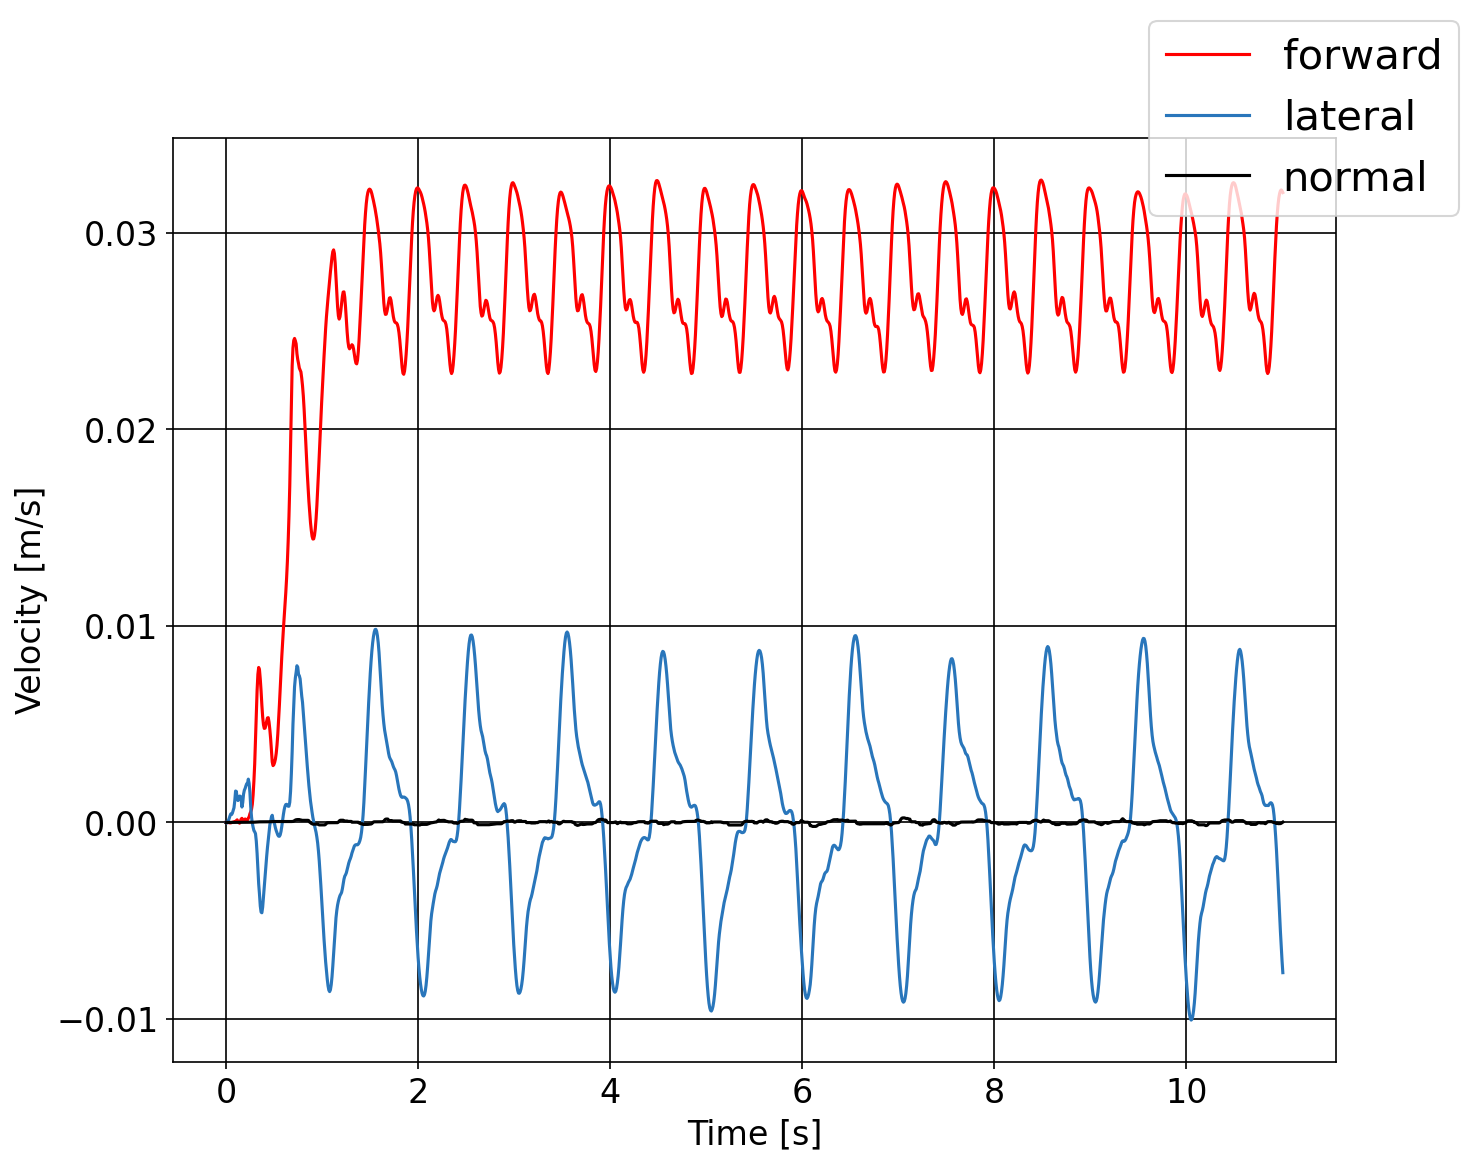

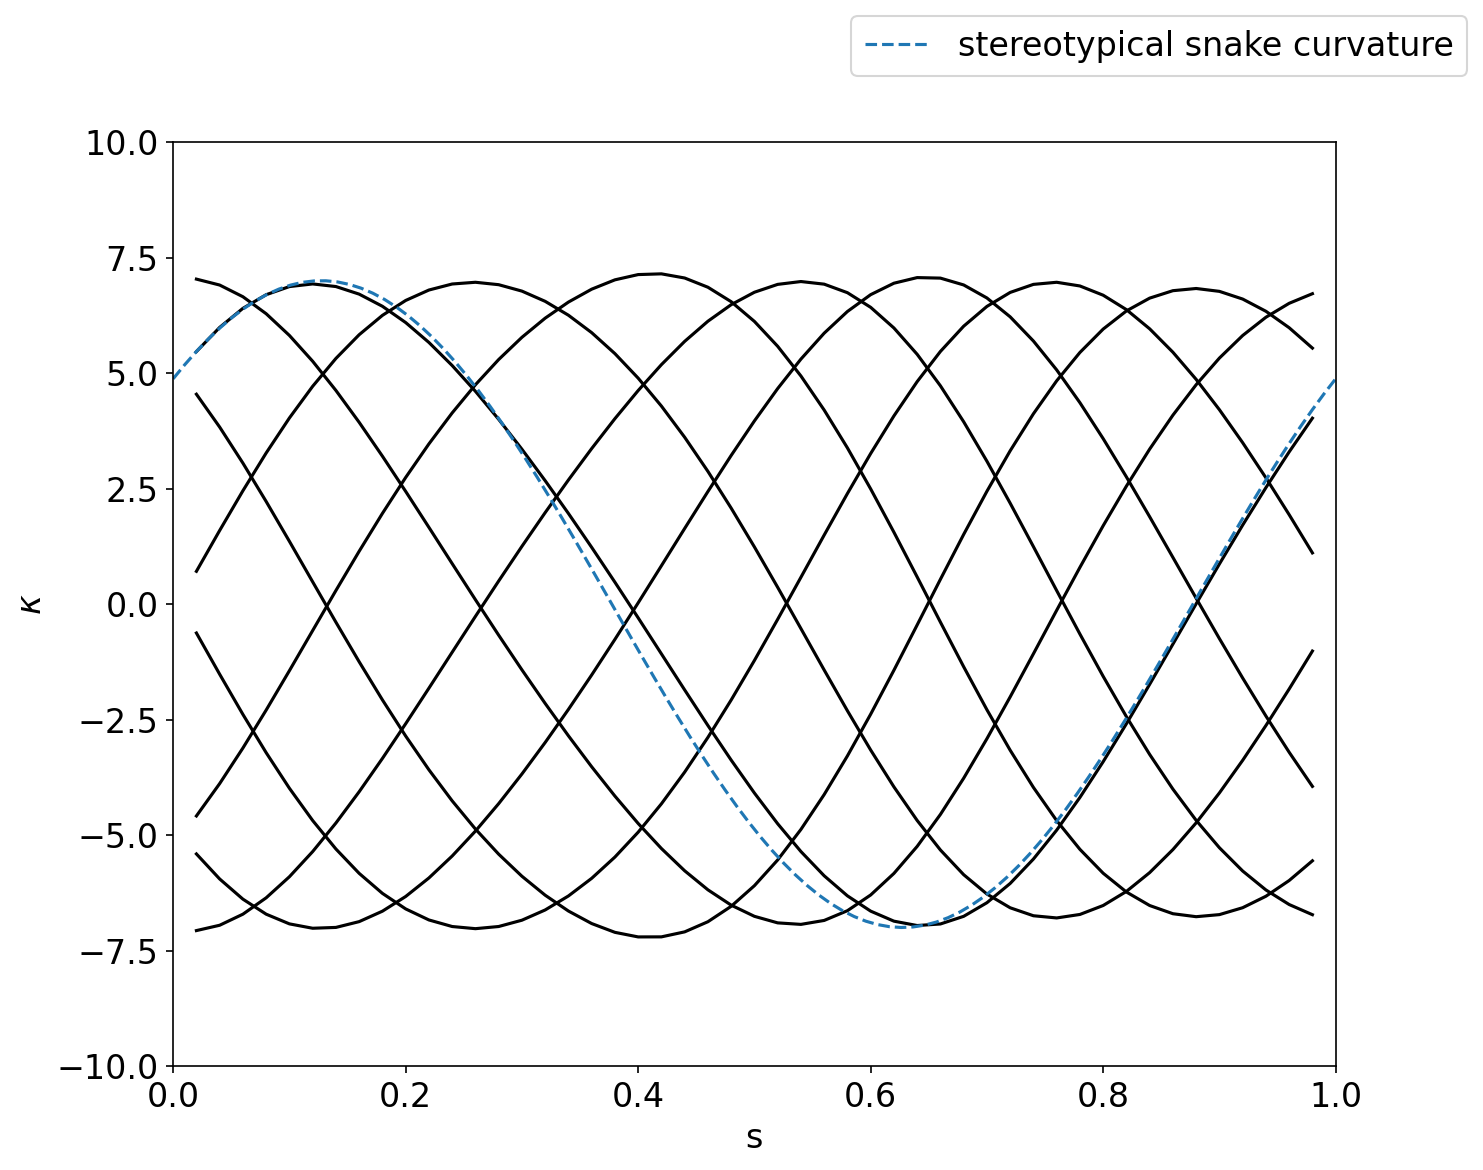

plot video


100%|██████████| 1326/1326 [00:21<00:00, 62.08it/s]


average forward velocity: 0.02778956031252423
average forward lateral: -0.002327264416082844


In [ ]:
__doc__ = """Snake friction case from X. Zhang et. al. Nat. Comm. 2021"""

import os
import numpy as np
import sys

# Point this to the actual PyElastica path
pyelastica_path = r'C:\Users\tawel\OneDrive\Documents\GitHub\PyElastica'
if pyelastica_path not in sys.path:
    sys.path.insert(0, pyelastica_path)

import elastica as ea  # this should now work


import matplotlib
import matplotlib.animation as animation

matplotlib.rcParams['animation.ffmpeg_path'] = r"C:\ffmpeg\ffmpeg-2025-06-11-git-f019dd69f0-full_build\bin\ffmpeg.exe"

print(animation.writers.list())  # should show ffmpeg in the list now

print(animation.writers.list())  # should include ffmpeg now

from examples.ContinuumSnakeCase.continuum_snake_postprocessing import (
    plot_snake_velocity,
    plot_video,
    compute_projected_velocity,
    plot_curvature,
)


class SnakeSimulator(
    ea.BaseSystemCollection,
    ea.Constraints,
    ea.Forcing,
    ea.modules.Damping,
    ea.CallBacks,
    ea.Contact,
):
    pass


def run_snake(
    b_coeff, PLOT_FIGURE=False, SAVE_FIGURE=False, SAVE_VIDEO=False, SAVE_RESULTS=False
):
    # Initialize the simulation class
    snake_sim = SnakeSimulator()

    # Simulation parameters
    period = 2
    final_time = (11.0 + 0.01) * period

    # setting up test params
    n_elem = 50
    start = np.zeros((3,))
    direction = np.array([0.0, 0.0, 1.0])
    normal = np.array([0.0, 1.0, 0.0])
    base_length = 0.35
    base_radius = base_length * 0.011
    density = 1000
    E = 1e6
    poisson_ratio = 0.5
    shear_modulus = E / (poisson_ratio + 1.0)

    shearable_rod = ea.CosseratRod.straight_rod(
        n_elem,
        start,
        direction,
        normal,
        base_length,
        base_radius,
        density,
        youngs_modulus=E,
        shear_modulus=shear_modulus,
    )

    snake_sim.append(shearable_rod)

    # Add gravitational forces
    gravitational_acc = -9.80665
    snake_sim.add_forcing_to(shearable_rod).using(
        ea.GravityForces, acc_gravity=np.array([0.0, gravitational_acc, 0.0])
    )

    # Add muscle torques
    wave_length = b_coeff[-1]
    snake_sim.add_forcing_to(shearable_rod).using(
        ea.MuscleTorques,
        base_length=base_length,
        b_coeff=b_coeff[:-1],
        period=period,
        wave_number=2.0 * np.pi / (wave_length),
        phase_shift=0.0,
        rest_lengths=shearable_rod.rest_lengths,
        ramp_up_time=period,
        direction=normal,
        with_spline=True,
    )

    # Add friction forces
    ground_plane = ea.Plane(
        plane_origin=np.array([0.0, -base_radius, 0.0]), plane_normal=normal
    )
    snake_sim.append(ground_plane)
    slip_velocity_tol = 1e-8
    froude = 0.1
    mu = base_length / (period * period * np.abs(gravitational_acc) * froude)
    kinetic_mu_array = np.array(
        [mu, 1.5 * mu, 2.0 * mu]
    )  # [forward, backward, sideways]
    static_mu_array = np.zeros(kinetic_mu_array.shape)
    snake_sim.detect_contact_between(shearable_rod, ground_plane).using(
        ea.RodPlaneContactWithAnisotropicFriction,
        k=1.0,
        nu=1e-6,
        slip_velocity_tol=slip_velocity_tol,
        static_mu_array=static_mu_array,
        kinetic_mu_array=kinetic_mu_array,
    )

    # add damping
    damping_constant = 2e-3
    time_step = 1e-4
    snake_sim.dampen(shearable_rod).using(
        ea.AnalyticalLinearDamper,
        damping_constant=damping_constant,
        time_step=time_step,
    )

    total_steps = int(final_time / time_step)
    rendering_fps = 60
    step_skip = int(1.0 / (rendering_fps * time_step))

    # Add call backs
    class ContinuumSnakeCallBack(ea.CallBackBaseClass):
        """
        Call back function for continuum snake
        """

        def __init__(self, step_skip: int, callback_params: dict):
            ea.CallBackBaseClass.__init__(self)
            self.every = step_skip
            self.callback_params = callback_params

        def make_callback(self, system, time, current_step: int):

            if current_step % self.every == 0:

                self.callback_params["time"].append(time)
                self.callback_params["step"].append(current_step)
                self.callback_params["position"].append(
                    system.position_collection.copy()
                )
                self.callback_params["velocity"].append(
                    system.velocity_collection.copy()
                )
                self.callback_params["avg_velocity"].append(
                    system.compute_velocity_center_of_mass()
                )

                self.callback_params["center_of_mass"].append(
                    system.compute_position_center_of_mass()
                )
                self.callback_params["curvature"].append(system.kappa.copy())

                return

    pp_list = ea.defaultdict(list)
    snake_sim.collect_diagnostics(shearable_rod).using(
        ContinuumSnakeCallBack, step_skip=step_skip, callback_params=pp_list
    )

    snake_sim.finalize()

    timestepper = ea.PositionVerlet()
    ea.integrate(timestepper, snake_sim, final_time, total_steps)

    if PLOT_FIGURE:
        filename_plot = "continuum_snake_velocity.png"
        plot_snake_velocity(pp_list, period, filename_plot, SAVE_FIGURE)
        plot_curvature(pp_list, shearable_rod.rest_lengths, period, SAVE_FIGURE)

        if SAVE_VIDEO:
            filename_video = "continuum_snake.mp4"
            plot_video(
                pp_list,
                video_name=filename_video,
                fps=rendering_fps,
                xlim=(0, 4),
                ylim=(-1, 1),
            )

    if SAVE_RESULTS:
        import pickle

        filename = "continuum_snake.dat"
        file = open(filename, "wb")
        pickle.dump(pp_list, file)
        file.close()

    # Compute the average forward velocity. These will be used for optimization.
    [_, _, avg_forward, avg_lateral] = compute_projected_velocity(pp_list, period)

    return avg_forward, avg_lateral, pp_list


if __name__ == "__main__":

    # Options
    PLOT_FIGURE = True
    SAVE_FIGURE = True
    SAVE_VIDEO = True
    SAVE_RESULTS = False
    CMA_OPTION = False

    if CMA_OPTION:
        import cma

        SAVE_OPTIMIZED_COEFFICIENTS = False

        def optimize_snake(spline_coefficient):
            [avg_forward, _, _] = run_snake(
                spline_coefficient,
                PLOT_FIGURE=False,
                SAVE_FIGURE=False,
                SAVE_VIDEO=False,
                SAVE_RESULTS=False,
            )
            return -avg_forward

        # Optimize snake for forward velocity. In cma.fmin first input is function
        # to be optimized, second input is initial guess for coefficients you are optimizing
        # for and third input is standard deviation you initially set.
        optimized_spline_coefficients = cma.fmin(optimize_snake, 7 * [0], 0.5)

        # Save the optimized coefficients to a file
        filename_data = "optimized_coefficients.txt"
        if SAVE_OPTIMIZED_COEFFICIENTS:
            assert filename_data != "", "provide a file name for coefficients"
            np.savetxt(filename_data, optimized_spline_coefficients, delimiter=",")

    else:
        # Add muscle forces on the rod
        if os.path.exists("optimized_coefficients.txt"):
            t_coeff_optimized = np.genfromtxt(
                "optimized_coefficients.txt", delimiter=","
            )
        else:
            wave_length = 1.0
            t_coeff_optimized = np.array(
                [3.4e-3, 3.3e-3, 4.2e-3, 2.6e-3, 3.6e-3, 3.5e-3]
            )
            t_coeff_optimized = np.hstack((t_coeff_optimized, wave_length))

        # run the simulation
        [avg_forward, avg_lateral, pp_list] = run_snake(
            t_coeff_optimized, PLOT_FIGURE, SAVE_FIGURE, SAVE_VIDEO, SAVE_RESULTS
        )

        print("average forward velocity:", avg_forward)
        print("average forward lateral:", avg_lateral)